<a href="https://colab.research.google.com/github/wishmasterk/Fine-Tune-BERT-for-Multi-Class-Sentiment-Classification-with-Twitter-Data/blob/main/IMDB_SENTIMENT_TRANSFORMERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 772.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempti

In [45]:
# If using TensorFlow, you can check with:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [28]:
import pandas as pd
df = pd.read_csv("/content/IMDB Dataset.csv")
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [29]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,0
review,0
sentiment,0


In [30]:
df['sentiment'].value_counts() # only two classes, +ve and -ve and a perfectly balanced dataset

,count
sentiment,
positive,25000
negative,25000


In [31]:
# Rename columns for compatibility
df.columns = ['text', 'label']

df['label'] = df['label'].map({'positive': 1, 'negative': 0})

**DATASET ANALYSIS**

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

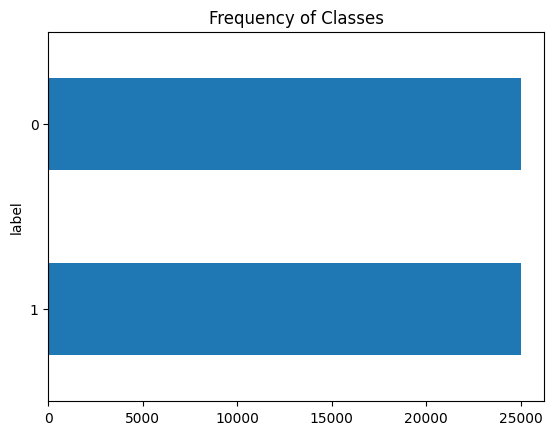

In [34]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per review'}, xlabel='label'>

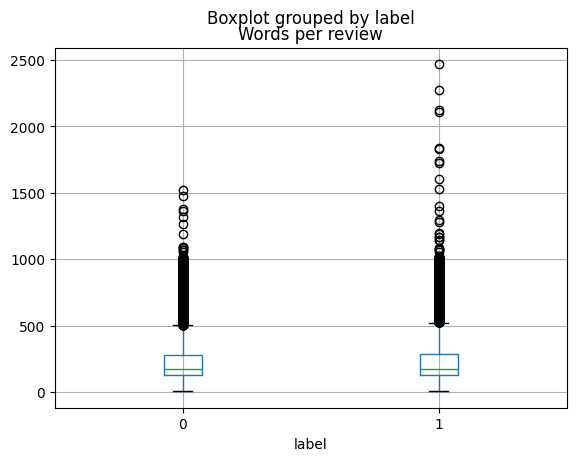

In [35]:
df['Words per review'] = df['text'].str.split().apply(len)
df.boxplot("Words per review", by="label")

#Text to Token Conversion

In [36]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=0.5, stratify=test['label'])
print(f"Train size: {train.shape[0]}, Validation size: {validation.shape[0]}, Test size: {test.shape[0]}")

Train size: 35000, Validation size: 7500, Test size: 7500


In [37]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [40]:
dataset['train'][0] # represents the first review of the train set along with the sentiment and num of words

{'text': "I was particularly moved by the understated courage and integrity of l'Anglaise, in this beautifully acted, intellectually and visually compelling film. Thank you so much, Monsieur le directeur Rohmer.",
 'label': 1,
 'Words per review': 29}

In [38]:
# Load the pre-trained model and tokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_name = 'distilbert-base-uncased'

text = "We love to sleep! Winters are awesome!"
encoded_text = tokenizer(text , return_tensors = "pt")
print(encoded_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  2057,  2293,  2000,  3637,   999, 12214,  2024, 12476,   999,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [39]:
len(tokenizer.vocab),tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

In [41]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

#Model Building

In [42]:
model = DistilBertForSequenceClassification.from_pretrained(model_name ,num_labels = 2) # initialize the model
print(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [43]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.0",
  "vocab_size": 30522
}

In [52]:
from transformers import TrainingArguments, Trainer
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [47]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [48]:
# Define metrics for evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


#Build Model and Trainer

In [53]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-53-d1a6b1557bfe>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [54]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.188800,0.205281,0.928800,0.928303,0.934830,0.921867
2,0.114600,0.222375,0.934933,0.934637,0.938913,0.930400


TrainOutput(global_step=4376, training_loss=0.19091441751316435, metrics={'train_runtime': 3592.5354, 'train_samples_per_second': 19.485, 'train_steps_per_second': 1.218, 'total_flos': 9272717905920000.0, 'train_loss': 0.19091441751316435, 'epoch': 2.0})

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
preds_output = trainer.predict(tokenized_dataset[ 'test'])
print(preds_output.metrics)

#Build Prediction function and save model

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [ ]:
# Download the zipped model
from google.colab import files
files.download("distilbert-sentiment-model.zip")

In [ ]:
# 9. Test Predictions
text_samples = ["This movie was amazing!", "I hated this film.", "It was just okay, nothing special."]
encoded_samples = tokenizer(text_samples, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model(**encoded_samples)
predicted_classes = outputs.logits.argmax(dim=1)
print(predicted_classes)  # Output: Tensor of predicted labels

In [ ]:
# make a file app.py, and use this code


# import streamlit as st
# from transformers import pipeline

# st.title("Fine-Tuning BERT for IMDB Sentiment Classification")

# classifier = pipeline('text-classification', model='distilbert-base-uncased-sentiment-model')

# text = st.text_area("Enter Your Tweet Here")

# if st.button("Predict"):
#         result = classifier(text)
#         st.write("Prediction Result:", result)

#